<a href="https://colab.research.google.com/github/Frecherenkel60/RandomForestRangers/blob/main/DataMining_RandomForestRangers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Rangers - Predicting Car Sales Prices

In [38]:
# Install dependencies
# !pip install -r requirements.txt
import warnings
warnings.filterwarnings("ignore")

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
# from minisom import MiniSom
# from sklearn.preprocessing import MinMaxScaler

In [40]:
#dataset = pd.read_csv('./data/used_car_prices_generated.csv')
data_split_read = pd.read_csv('./data/0_Data_Split/train.csv')
dataset_pre = pd.read_csv('./split_data/1_Preprocessing/train.csv')
# Remove the last 3 characters (' mi') and convert to float
data_split_read['milage'] = data_split_read['milage'].str[:-3]  # Remove last 3 characters
data_split_read['milage'] = data_split_read['milage'].str.replace(',', '')  # Remove commas
data_split_read['milage'] = data_split_read['milage'].astype(float)  # Convert to float

dataset_pre = dataset_pre.drop('Is_Luxury', axis = 1)

# Merge the 'brand' column from the data_split_read dataset into after_preprocessing
data_split = dataset_pre.merge(
    data_split_read[['price', 'milage', 'brand']],
    on=['price', 'milage'],
    how='left'  # Use 'left' to retain all rows in after_preprocessing
)
print(data_split.describe())


        model_year         milage     accident  clean_title          price  \
count  3203.000000    3203.000000  3203.000000  3203.000000    3203.000000   
mean   2015.456759   65663.416485     0.278489     0.854199   40030.960662   
std       6.137523   52560.486264     0.448325     0.352962   36735.288148   
min    1974.000000     100.000000     0.000000     0.000000    2000.000000   
25%    2012.000000   23567.500000     0.000000     1.000000   17000.000000   
50%    2017.000000   54000.000000     0.000000     1.000000   31000.000000   
75%    2020.000000   95000.000000     1.000000     1.000000   48994.500000   
max    2024.000000  405000.000000     1.000000     1.000000  289991.000000   

             turbo    is_hybrid  is_gasoline  is_electric  engine_score  
count  3203.000000  3203.000000  3203.000000  3203.000000   3203.000000  
mean      0.071808     0.058383     0.825164     0.036216      0.074680  
std       0.258210     0.234502     0.379886     0.186856      0.581442  
m

## Some interesting plots and insights from the data_split

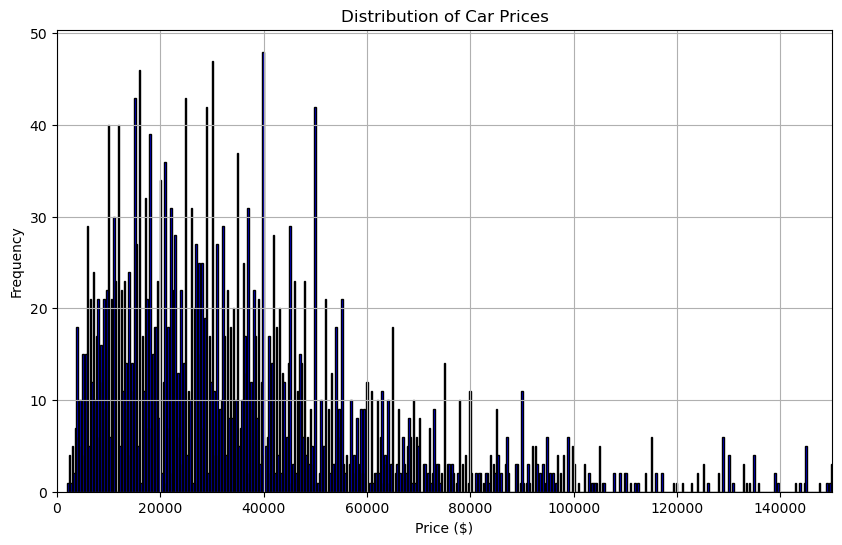

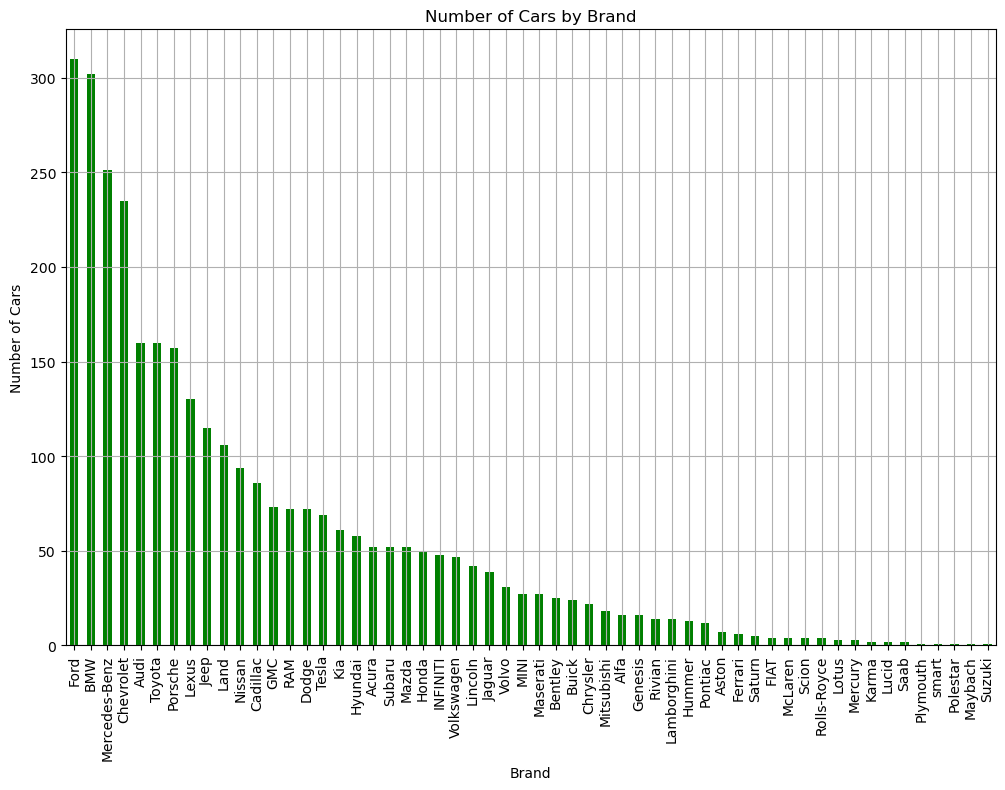

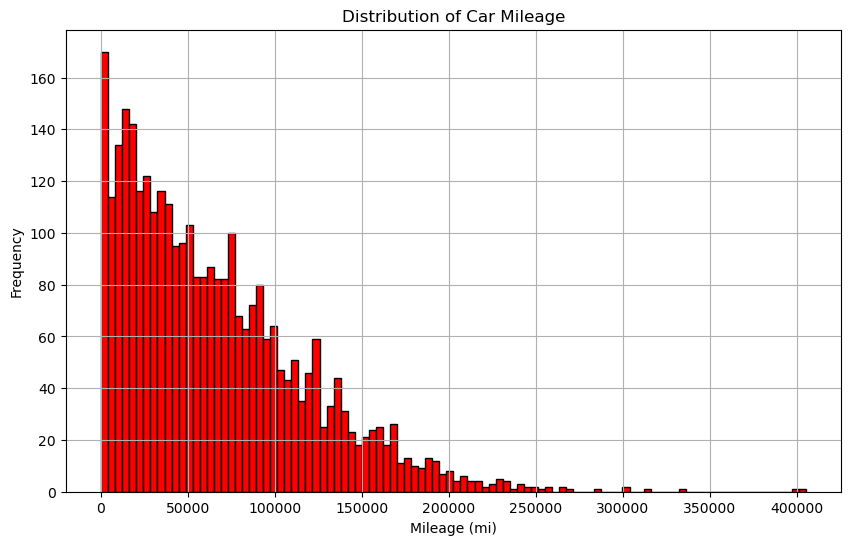

In [41]:
# Plot distribution of car prices
plt.figure(figsize=(10, 6))
plt.hist(data_split['price'].dropna(), bins=1000, color='blue', edgecolor='black')
plt.title('Distribution of Car Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0,150000)
plt.show()


# Plot number of cars by brand
plt.figure(figsize=(12, 8))
data_split['brand'].value_counts().plot(kind='bar', color='green')
plt.title('Number of Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Cars')
plt.grid(True)
plt.show()

# Plot distribution of mileage
plt.figure(figsize=(10, 6))
plt.hist(data_split['milage'].dropna(), bins=100, color='red', edgecolor='black')
plt.title('Distribution of Car Mileage')
plt.xlabel('Mileage (mi)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Highlevel EDA of multiple attributes thought to be essential (by domain knowledge)

## Effect of model year and/or milage on price

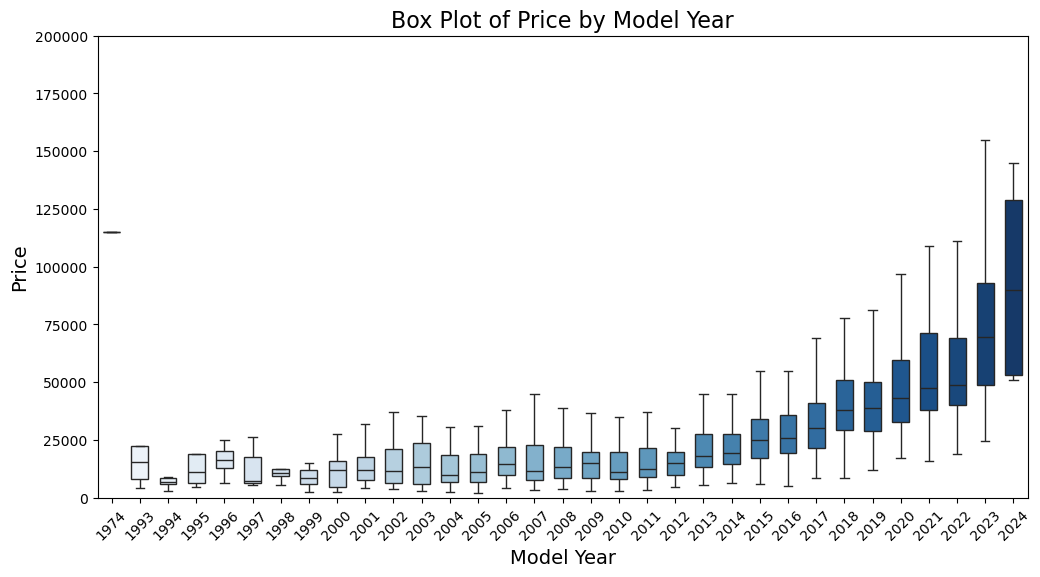

In [42]:

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', split_data=data_split, palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=data_split, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(data_split['model_year'].unique()), 5), labels=data_split['model_year'].unique()[::5])
plt.ylim(0,200000)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.show()




Here we can see that 1974 and 1997 are highly seperated. The distribution of the means (and in general boxplots) seems to show an exponential relationship. There is a price deep in 1998 and 1994 compared to their "neighbor years". In general the whiskers are quite wide. However, the older the vehicle, the smaller the whiskers but also smaller boxes. We can say that the prices in absolute terms are less spread the older the vehicle is. Thus, we can expect higher price prediction accuracy on older vehicles.

TODO: Hence, being able to reduce the variance of the cars or trying to find variables that explain the variance is vital.


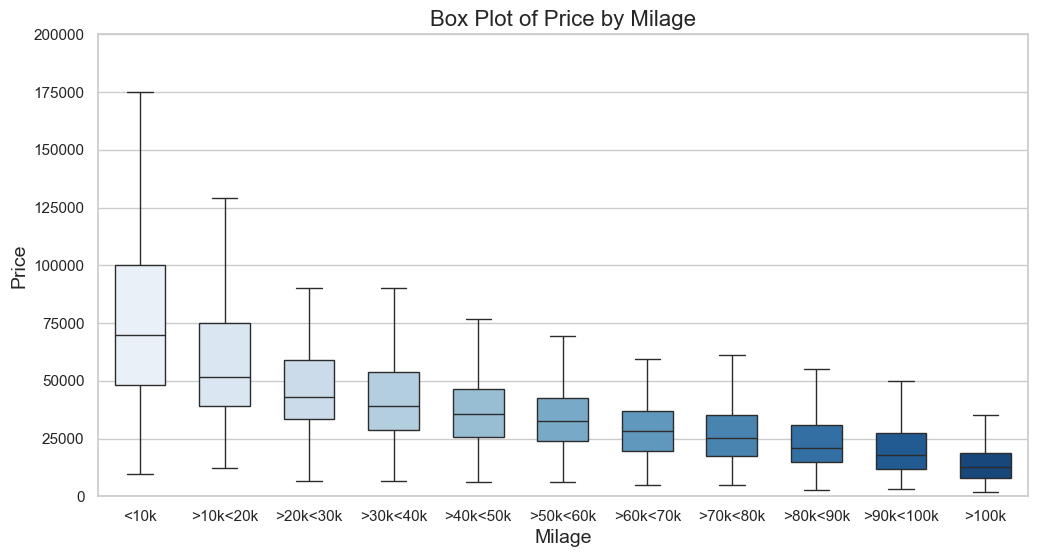

milage_category
<10k         99962.25
>10k<20k     75000.00
>20k<30k     58824.50
>30k<40k     53699.50
>40k<50k     46599.00
>50k<60k     42624.25
>60k<70k     37000.00
>70k<80k     35000.00
>80k<90k     31000.00
>90k<100k    27499.25
>100k        18800.00
Name: price, dtype: float64


In [55]:
# Define the bins for the Mileage categories
mileage_bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, float('inf')]
mileage_labels = ['<10k', '>10k<20k', '>20k<30k', '>30k<40k', '>40k<50k', '>50k<60k', '>60k<70k', '>70k<80k', '>80k<90k', '>90k<100k', '>100k']

# Create the Mileage categories
data_split['milage_category'] = pd.cut(data_split['milage'], bins=mileage_bins, labels=mileage_labels, right=False)



# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_category', y='price', data=data_split, palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=data_split, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Milage', fontsize=16)
plt.xlabel('Milage', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(data_split['model_year'].unique()), 5), labels=data_split['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()
# Calculate the 75th percentile for price in each Mileage Category
percentile_75 = data_split.groupby('milage_category')['price'].quantile(0.75)

# Print the 75th percentile for each category
print(percentile_75)

## Creating Correlation matrices

### Creating a brand_index based on mean car price by car since brand is a string and cant be depicted on a corr matrix

In [46]:
# Group by 'brand' and calculate the mean price
grouped = data_split.groupby('brand', as_index=False)['price'].mean()

# Sort by mean price in descending order
grouped = grouped.sort_values(by='price', ascending=False)

# Add a 'brand_index' column, assigning ranks (1 for highest)
grouped['brand_index'] = range(1, len(grouped) + 1)

# Merge back to the original DataFrame if needed
new_cars = data_split.merge(grouped[['brand', 'brand_index']], on='brand', how='left')
new_cars = new_cars.drop(['brand', 'milage_category'], axis=1)

# Display the result
print(new_cars)

      model_year    milage  accident  clean_title  price  turbo  is_hybrid  \
0           2000  194277.0         1            1   2300      0          0   
1           2015   13300.0         0            1  62500      0          0   
2           2020   30426.0         1            0  29645      0          0   
3           2020   67072.0         0            1  38500      0          0   
4           2016   99000.0         1            1   5000      0          0   
...          ...       ...       ...          ...    ...    ...        ...   
3198        2004   34254.0         0            1  64250      0          0   
3199        2013   99982.0         1            1   6900      0          0   
3200        1993  120644.0         0            1   4200      0          0   
3201        2021   31181.0         1            1  42442      0          0   
3202        2007   82000.0         1            1   7999      0          0   

      is_gasoline  is_electric  engine_score  brand_index  
0  

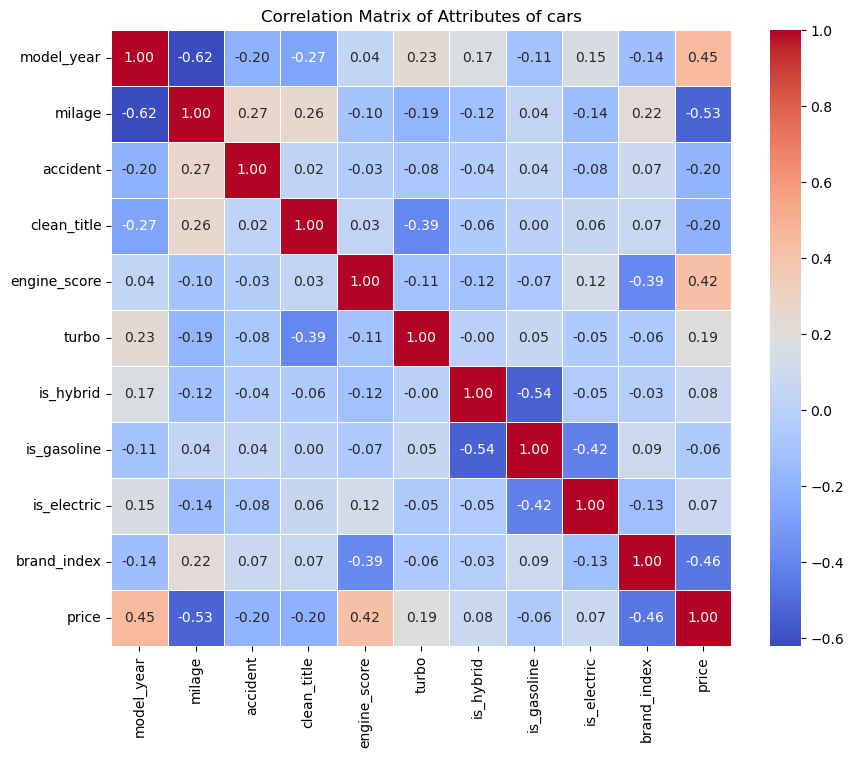

In [48]:
# Correlation matrix
# datapre

# Get the list of columns
columns = list(new_cars.columns)

# Find the indexes of the 'price' and 'engine_score' columns
price_index = columns.index('price')
engine_score_index = columns.index('brand_index')

# Swap their positions in the columns list
columns[price_index], columns[engine_score_index] = columns[engine_score_index], columns[price_index]

# Reorder the DataFrame using the modified columns list
new_cars = new_cars[columns]

corr_matrix = new_cars.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Attributes of cars')
plt.show()

In [49]:
# Find the lowest price for each model year
lowest_price_by_year = data_split.groupby('model_year')['price'].min().reset_index()

lowest_price_by_year
data_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   model_year       3203 non-null   int64   
 1   milage           3203 non-null   float64 
 2   accident         3203 non-null   int64   
 3   clean_title      3203 non-null   int64   
 4   price            3203 non-null   int64   
 5   turbo            3203 non-null   int64   
 6   is_hybrid        3203 non-null   int64   
 7   is_gasoline      3203 non-null   int64   
 8   is_electric      3203 non-null   int64   
 9   engine_score     3203 non-null   float64 
 10  brand            3203 non-null   object  
 11  milage_category  3203 non-null   category
dtypes: category(1), float64(2), int64(8), object(1)
memory usage: 278.9+ KB


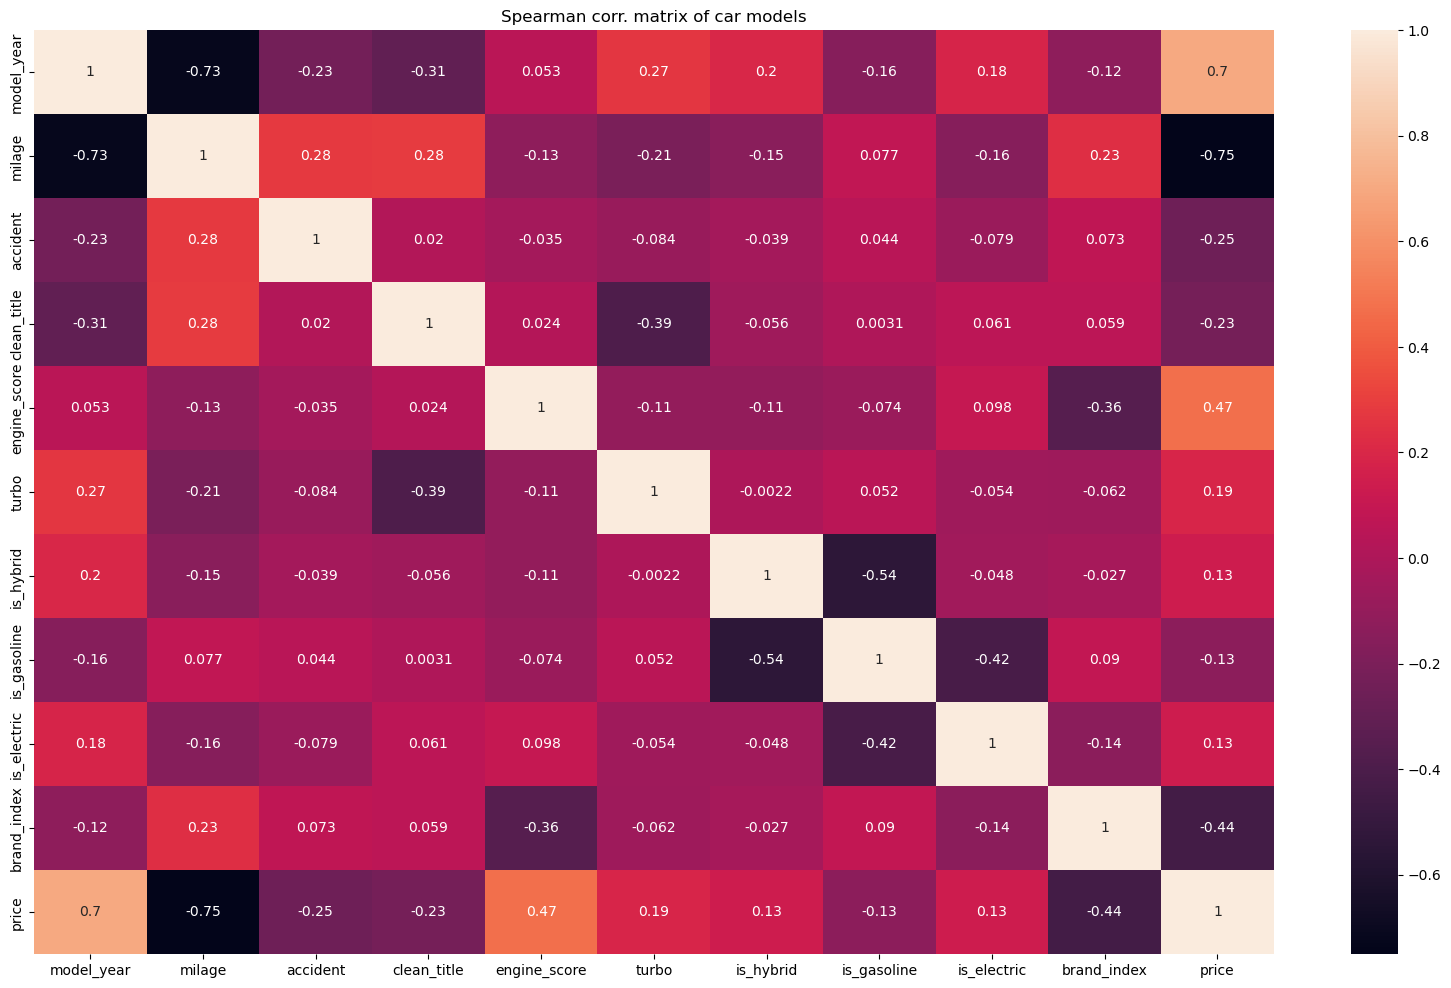

In [50]:
#Spearman alle 
corr = new_cars.corr(method = 'spearman')
plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot = True)
plt.title("Spearman corr. matrix of car models")
plt.show()

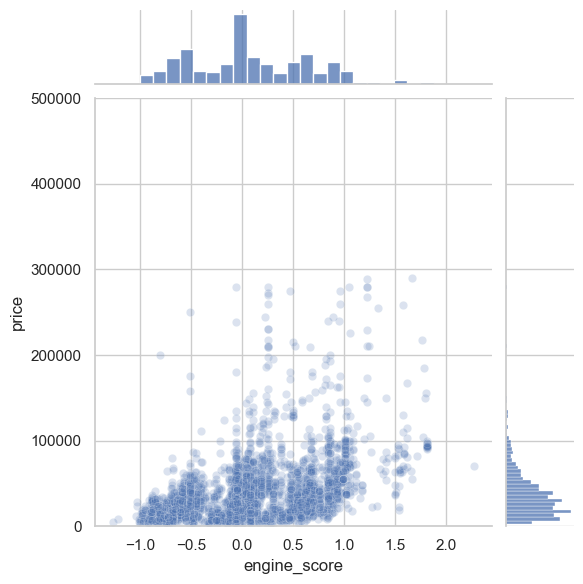

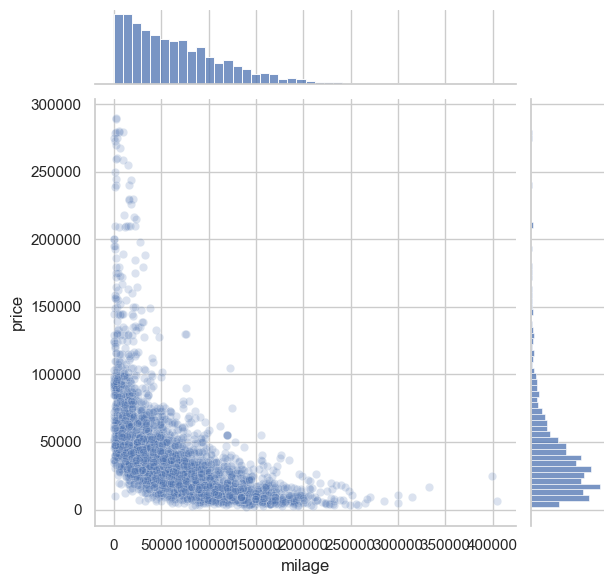

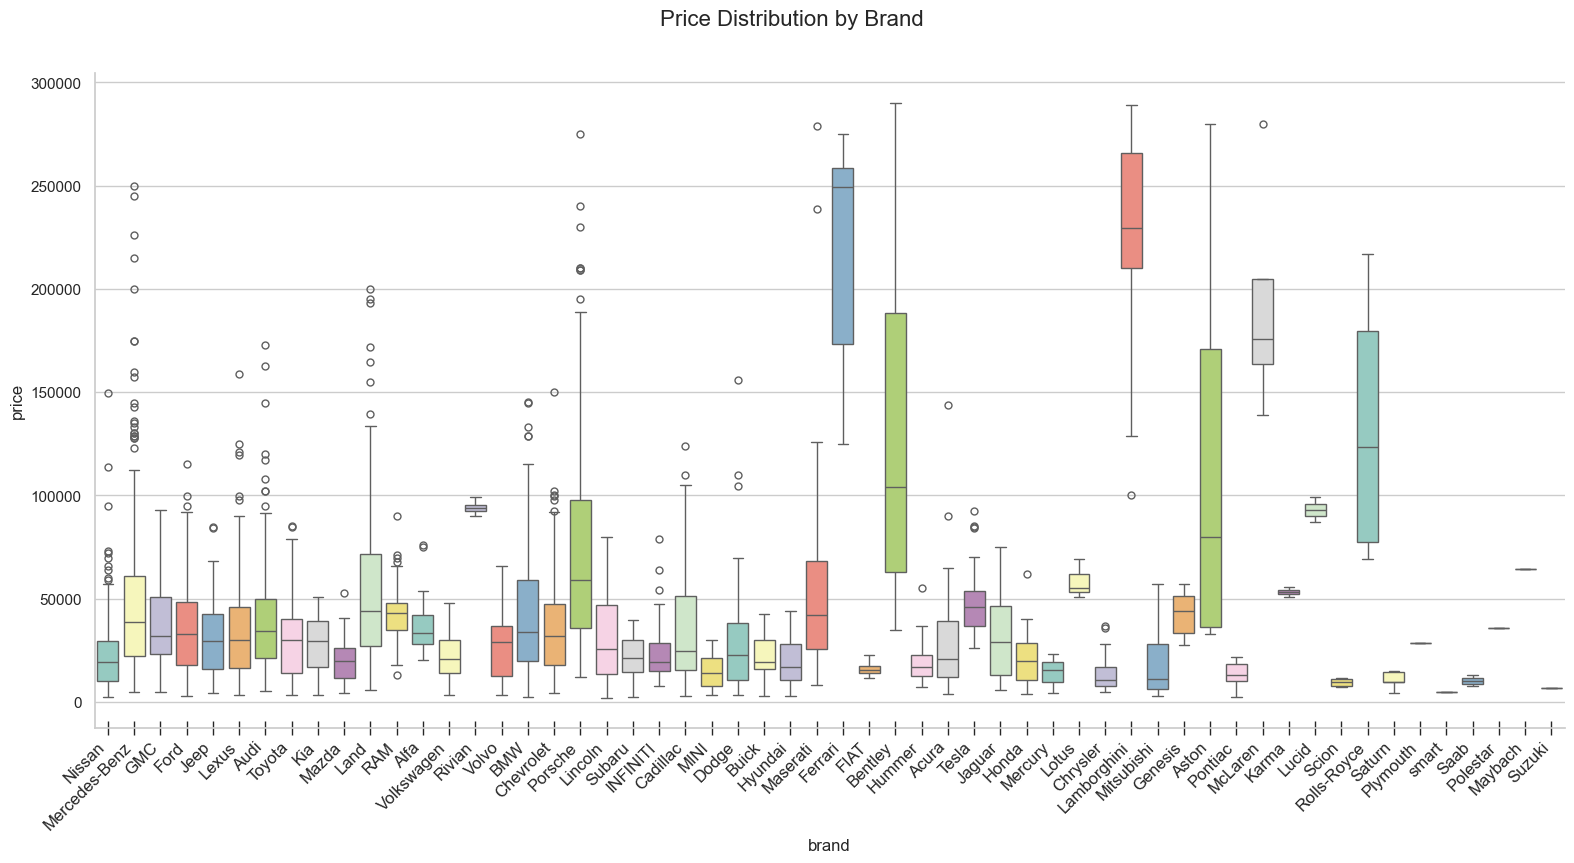

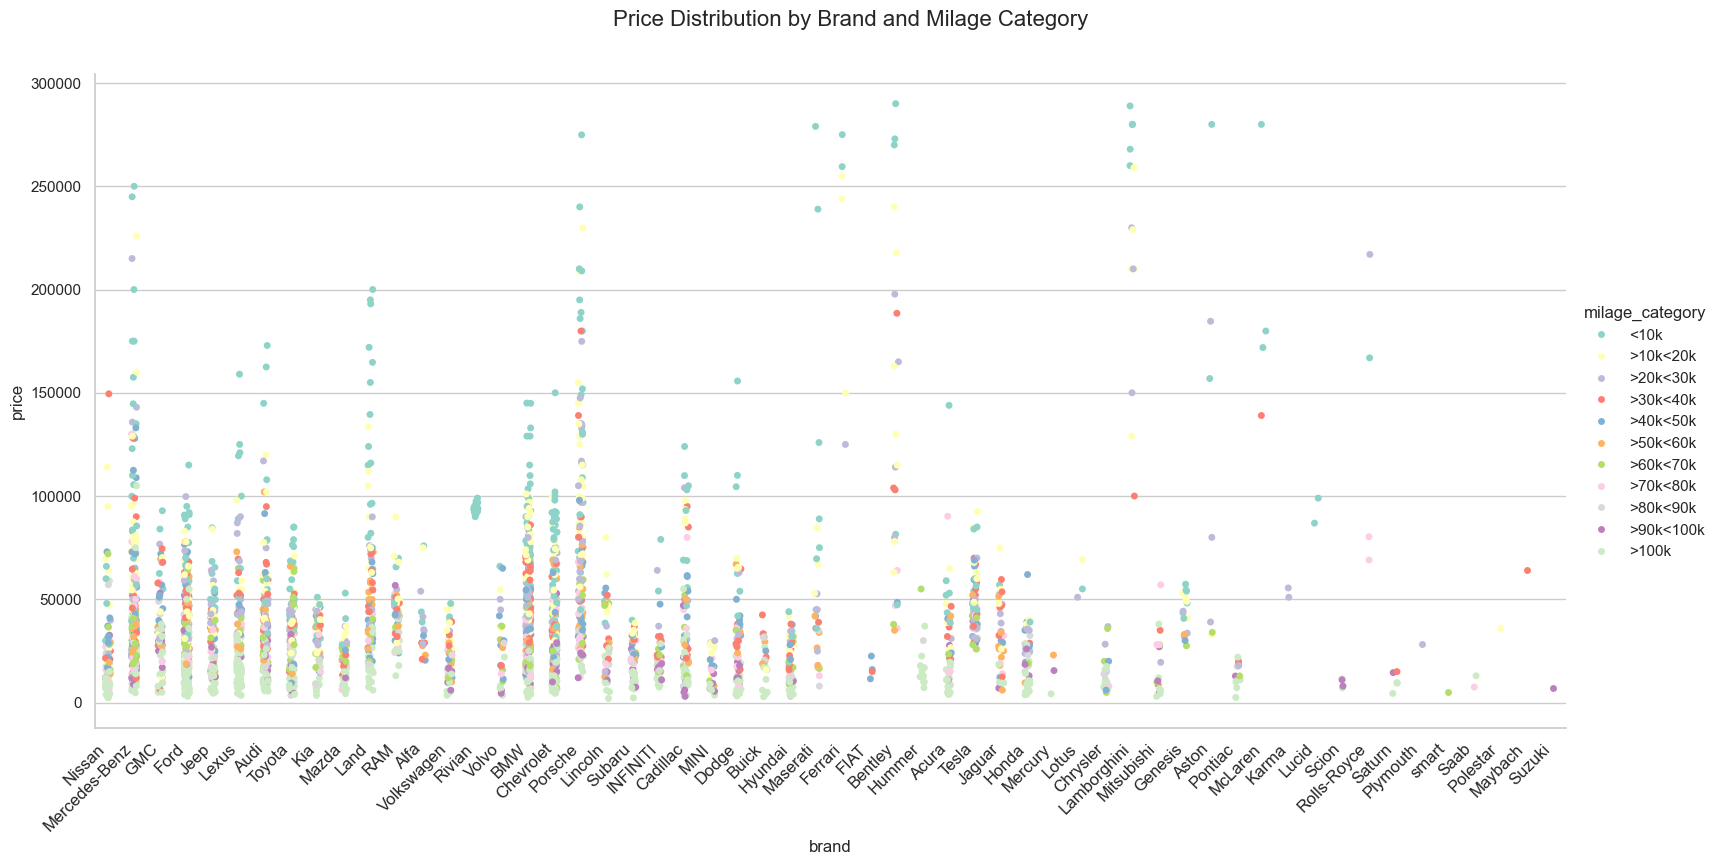

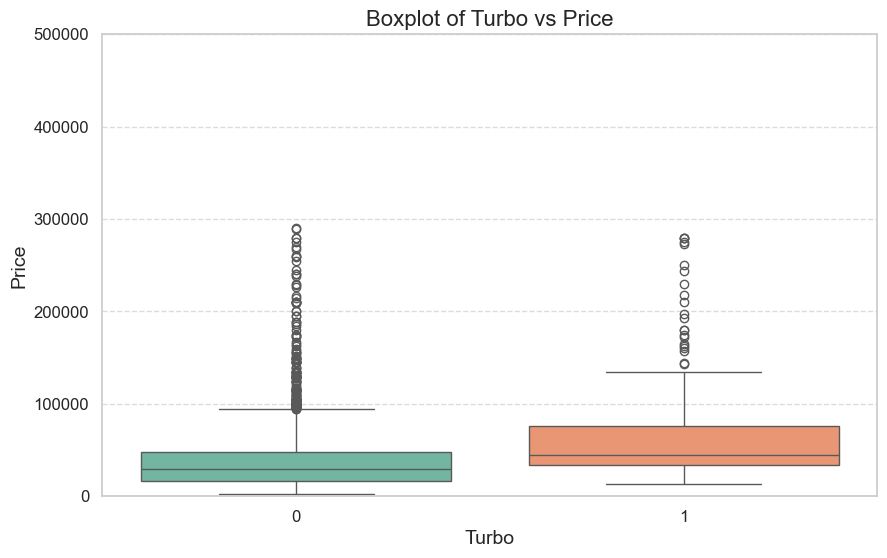

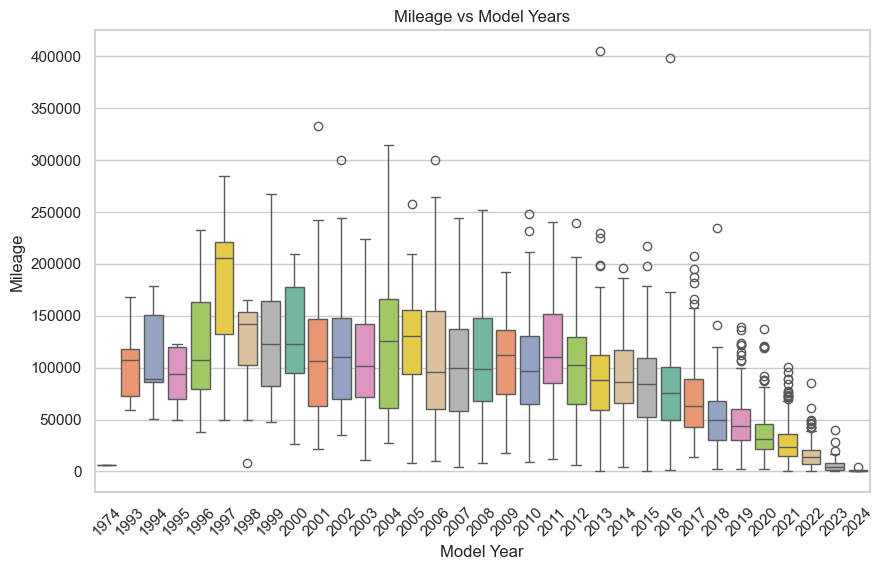

In [60]:
sns.jointplot(x="engine_score", y="price", data=data_split, alpha=0.2, ylim= (0,500000))
# Assuming 'is_luxury' is a categorical variable indicating luxury status
sns.jointplot(x="milage", y="price", data=data_split, alpha=0.2)

plt.show()

## Set theme for the plot
sns.set_theme(style="whitegrid")

# Create the boxplot using catplot
g = sns.catplot(
    data=data_split,
    x="brand",
    y="price",
    kind="box",
    height=8,
    aspect=2,  # Adjust height and aspect ratio
    palette="Set3"
)

# Rotate x-axis labels for readability
g.set_xticklabels(rotation=45, ha="right", fontsize=12)

# Customize tick markers
plt.tick_params(axis='x', which='both', bottom=True, top=False, direction='inout', length=10, width=1)

# Enhance the plot
g.fig.subplots_adjust(top=0.9)  # Adjust top space for title
g.fig.suptitle("Price Distribution by Brand", fontsize=16)

# Show the plot
plt.show()

# Set theme for the plot
sns.set_theme(style="whitegrid")

# Create the scatter plot using catplot
g = sns.catplot(
    data=data_split,
    x="brand",
    y="price",
    hue="milage_category",  # Color points by 'milage_category'
    kind="strip",           # Use strip plot for scatter points on categories
    height=8,
    aspect=2,               # Adjust height and aspect ratio
    jitter=True,            # Add jitter for better visualization
    palette="Set3"          # Choose a color palette
)

# Rotate x-axis labels for readability
g.set_xticklabels(rotation=45, ha="right", fontsize=12)

# Enhance the plot
g.fig.subplots_adjust(top=0.9)  # Adjust top space for title
g.fig.suptitle("Price Distribution by Brand and Milage Category", fontsize=16)

# Show the plot
plt.show()


# Boxplot of turbo vs price
plt.figure(figsize=(10, 6))
sns.boxplot(x="turbo", y="price", data=data_split, palette="Set2")

# Enhance the plot
plt.title("Boxplot of Turbo vs Price", fontsize=16)
plt.xlabel("Turbo", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,500000)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Filter to show only every 5th year
filtered_data = data_split

# Boxplot with fewer years
plt.figure(figsize=(10, 6))
sns.boxplot(x="model_year", y="milage", data=filtered_data, palette="Set2")

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.title("Mileage vs Model Years")
plt.xlabel("Model Year")
plt.ylabel("Mileage")

plt.show()


We can see that there are a lot of potential outliers when determining the price of a car based on its brand. It seems like some brands are usually more expensive than others like Aston, Bentley, Porsche, Lambourghini, Ferrrari, MCLaren and Rolse-Royce. Mercedes-Benz has plenty of cars that are priced high which are indicated as pot outliers. However, MB has a wide portfolio, from afforable to luxury cars. Interestingly, Maserati isnt part of the higher priced cars. In gerneral, we can see that brands that (mainly) offer luxury products are higher priced. TODO: Potentially we can use this as an attribute in feature engineering.
Furthermore, we find that  cars are usually more expensive when they have a turbo. However, these also have plenty of pot. outliers. TODO: It would be interesting to see what attribues make the cars be outliers.
We can also see an unusual spike in amount of cars and price at the 300 engine_score mark. It reminds of a steep normal distribution. engine_score has a positive relationship with price, however, the variance is large, indicating there are more important variables to be considered (in parallel). After the 300 HP mark, the variance of HP-price significantly increases. Indicating that there are other attributes that are more important at that point.
It seems like the hypothesis regarding the increase in variance of price since 2010 is true: The Median decreases, whereby in earlier years it stays steady or goes up

# Examining the differnece luxury cars make in prices -> Creating appropriate attributes

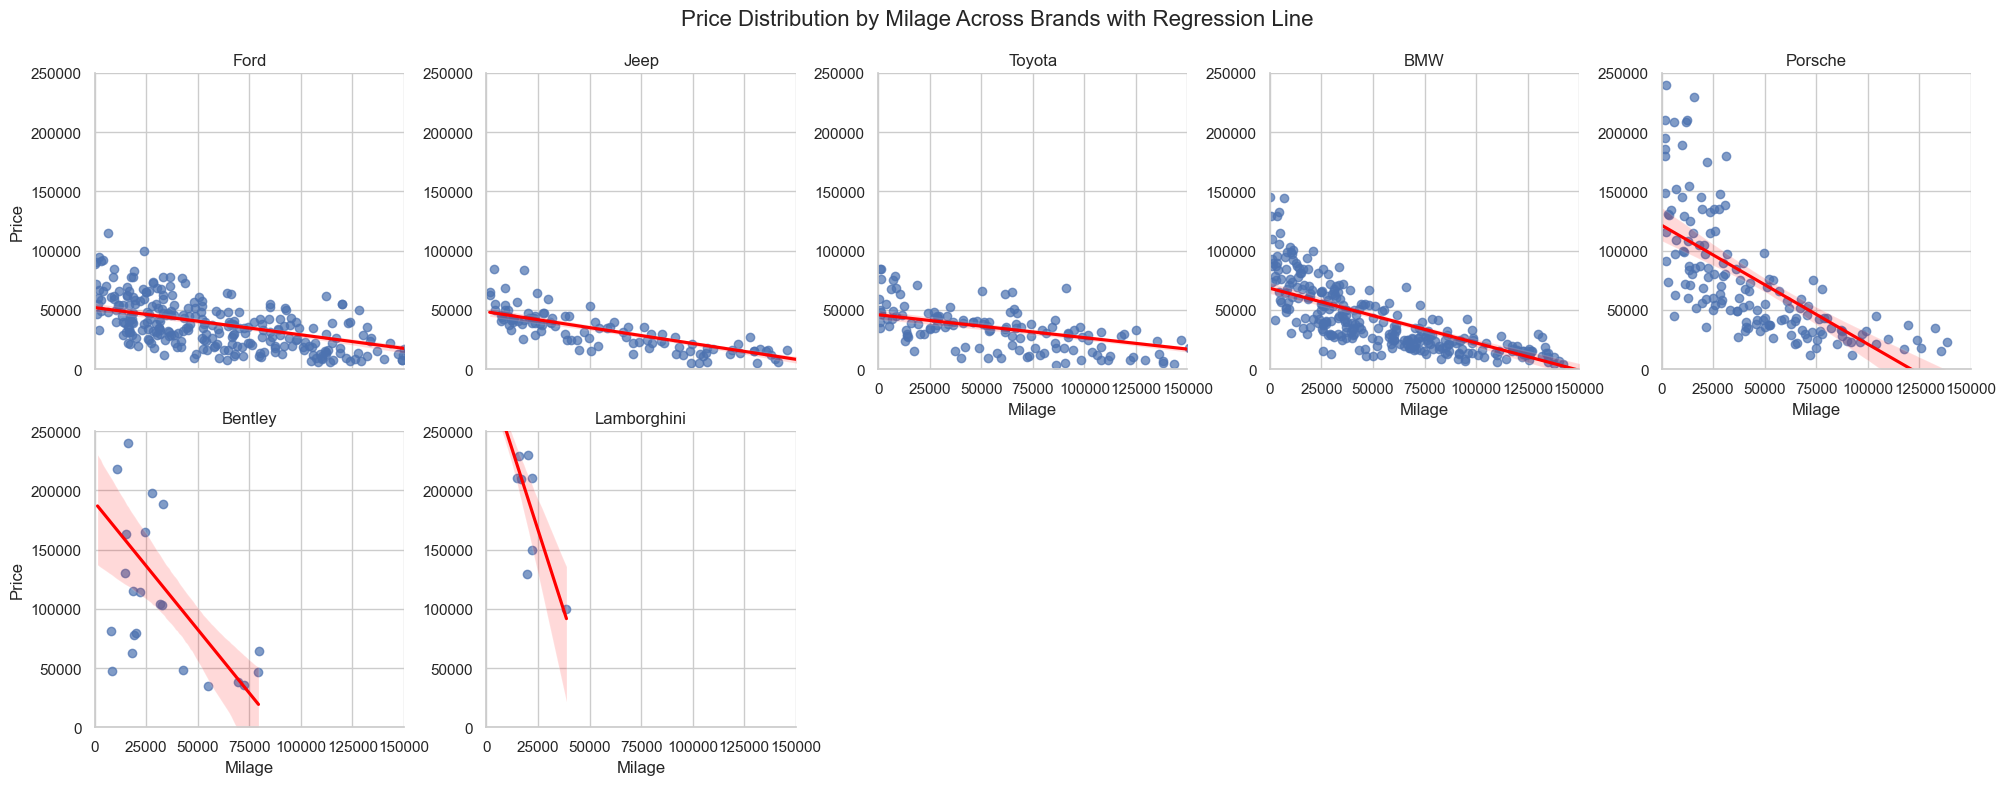

In [115]:
# Filter data to include only the specified brands
luxury_brands = ["Jeep", "Bentley", "Porsche", "Lamborghini", "Toyota", "BMW", "Ford"]
filtered_data = data_split[data_split["brand"].isin(luxury_brands)]

# Create a FacetGrid
g = sns.FacetGrid(filtered_data, col="brand", col_wrap=5, height=4, sharey=False)

# Map scatterplot with regression line to each facet
g.map_dataframe(sns.regplot, x="milage", y="price", scatter_kws={'alpha': 0.7}, line_kws={'color': 'red'})

# Add a legend for hue (if needed)
g.add_legend()

# Set x and y limits for all plots
g.set(xlim=(0, 150000), ylim=(0, 250000))  # Set x and y limits

# Add titles and labels
g.set_axis_labels("Milage", "Price")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Price Distribution by Milage Across Brands with Regression Line", fontsize=16)

# Show the plot
plt.show()


Although, the correlations matrices (spearmann and pearson) indicate that brand isnt correlated with the price, we can see that it is still an important factor in dterming the price. For example, a vehicle with a milage of 40k from Toyota is priced from around 10k-70k, most of them being around 40k. Cars with the same milage of the brand Porsche, on the other hand, are around the 100-130k price tag. This is a difference of factor 2 to 3. Thus, we need to create attributes that differentiate these types of cars from the others so the model hopefully has a easier time determining car prices

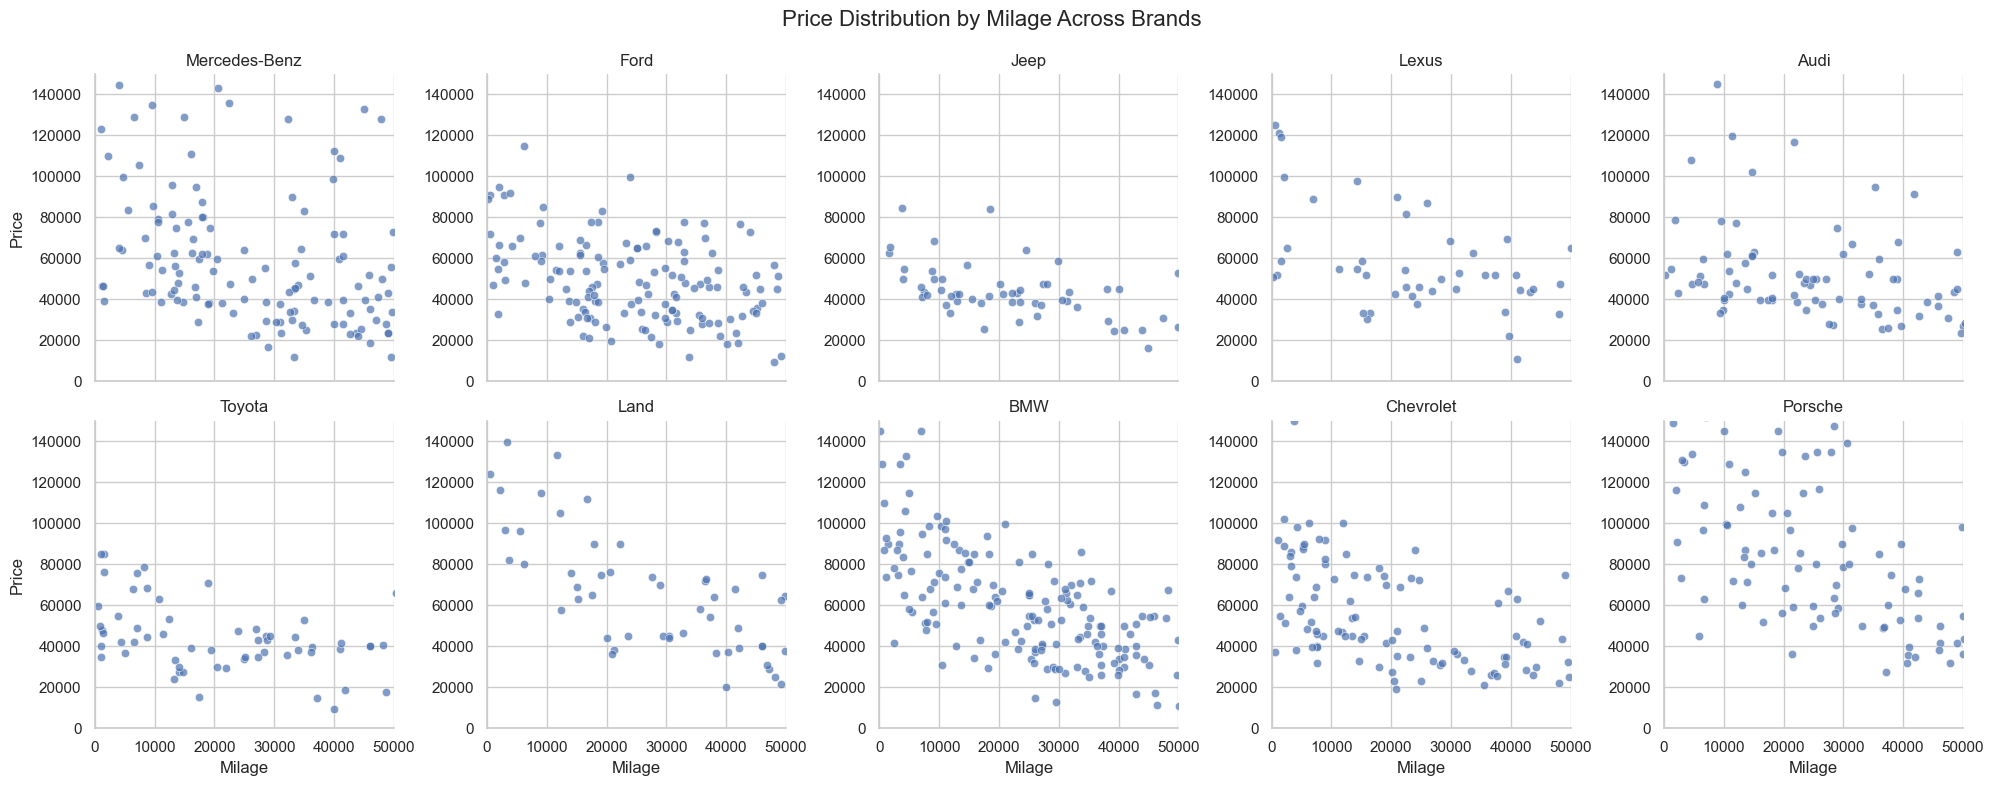

In [76]:
# Limit to top 10 brands and drop rows with missing prices
filtered_data = data_split.dropna(subset=['price'])
top_brands = filtered_data['brand'].value_counts().nlargest(10).index
filtered_data = filtered_data[filtered_data['brand'].isin(top_brands)]

# Create a FacetGrid
g = sns.FacetGrid(filtered_data, col="brand", col_wrap=5, height=4, sharey=False)

# Map scatterplot to each facet
g.map_dataframe(sns.scatterplot, x="milage", y="price", alpha=0.7)

# Set x and y limits for all plots
g.set(xlim=(0, 50000), ylim=(0, 150000))

# Add titles and labels
g.set_axis_labels("Milage", "Price")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Price Distribution by Milage Across Brands", fontsize=16)

# Show the plot
plt.show()


The plot(s) shows that the value of cars is negativly impacted by the milage. However, some brands aren't as susceptible to this reducation as others. For example, higher status brands like Porsche have a strong negativ relationship. Toyota on the other side has a moderate negativ relationship. 
In general, we can see that higher priced cars lose a larger portion of their value per mile driven.

### Creating classes that devide the brand into luxury, upper and normal class

In [65]:
# Define the bins for the Mileage categories
mileage_bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, float('inf')]
mileage_labels = ['<10k', '>10k<20k', '>20k<30k', '>30k<40k', '>40k<50k', '>50k<60k', '>60k<70k', '>70k<80k', '>80k<90k', '>90k<100k', '>100k']

# Create the Mileage categories
data_split['milage_category'] = pd.cut(data_split['milage'], bins=mileage_bins, labels=mileage_labels, right=False)

# Calculate the 75th percentile for price in each Mileage Category
percentile_75 = data_split.groupby('milage_category')['price'].quantile(0.75)

# Function to filter cars above the 75th percentile for each brand
def filter_above_percentile(df, percentile_75):
    results = []
    
    for category, threshold in percentile_75.items():
        # Filter cars with Price > 75th percentile for the given category
        filtered = df[(df['milage_category'] == category) & (df['price'] > threshold)]
        
        # Calculate absolute and relative counts for each brand
        absolute_count = filtered.groupby('brand').size()
        total_count = df[df['milage_category'] == category].groupby('brand').size()
        relative_count = absolute_count / total_count
        
        # Store results
        for brand in absolute_count.index:
            results.append({
                'brand': brand,
                'milage_category': category,
                'Absolute_Above_75th': absolute_count[brand],
                'Relative_Above_75th': relative_count[brand]
            })
    
    return pd.DataFrame(results)

# Filter and calculate the results
filtered_results = filter_above_percentile(data_split, percentile_75)
# Calculate the average of `Relative_Above_75th` for each Mileage Category
category_avg = filtered_results.groupby('brand')['Relative_Above_75th'].mean()

# Filter categories where the average is greater than 0.8 (80%)
categories_above_80_percent = category_avg[category_avg > 0.8].to_frame()
print(categories_above_80_percent)

# Filter categories where the average is greater than 0.8 (80%)
categories_above_50_below_80_percent = category_avg[(category_avg > 0.5) & (category_avg < 0.8)].to_frame()
print(categories_above_50_below_80_percent)


             Relative_Above_75th
brand                           
Aston                   0.833333
Bentley                 0.922449
Ferrari                 1.000000
Lamborghini             1.000000
Maybach                 1.000000
McLaren                 1.000000
Rolls-Royce             1.000000
         Relative_Above_75th
brand                       
Hummer              0.590909
Lincoln             0.506667
Porsche             0.604738
RAM                 0.605138
Tesla               0.607333


Emils Feature engineering: We create 2 more attribues called "Is_Luxury" and "Is_Upper_class". The former are brands which cars are above the 75th percentile 80% of the time. The later below 80% and above 50% of the time. The rest are considered to be normal.

In [66]:
luxury_brands = categories_above_80_percent.index.tolist()
upper_class_brands = categories_above_50_below_80_percent.index.tolist()

# Add the 'Is_Luxury' column: 1 if the brand is in the luxury list, otherwise 0
data_split['Is_Luxury'] = np.where(data_split['brand'].isin(luxury_brands), 1, 0)
data_split['Is_Upper_class'] = np.where(data_split['brand'].isin(upper_class_brands), 1, 0)


data_split["age"] = 2024 - data_split["model_year"]

# Define the conditions and corresponding values
conditions = [
    data_split["Is_Luxury"] == 1,  # If Is_Luxury is 1
    data_split["Is_Upper_class"] == 1  # If Is_Upper_class is 1
]

# Define the corresponding values for each condition
values = [2, 1]  # 2 for Is_Luxury=1, 1 for Is_Upper_class=1

# Add the 'luxury_type' column based on the conditions
data_split["luxury_type"] = np.select(conditions, values, default=0)

data_split

,model_year,milage,accident,clean_title,price,turbo,is_hybrid,is_gasoline,is_electric,engine_score,brand,milage_category,Is_Luxury,Is_Upper_class,age,luxury_type
0,2000,194277.0,1,1,2300,0,0,1,0,-0.318,Nissan,>100k,0,0,24,0
1,2015,13300.0,0,1,62500,0,0,1,0,0.682,Mercedes-Benz,>10k<20k,0,0,9,0
2,2020,30426.0,1,0,29645,0,0,1,0,-0.454,GMC,>30k<40k,0,0,4,0
3,2020,67072.0,0,1,38500,0,0,1,0,0.136,Ford,>60k<70k,0,0,4,0
4,2016,99000.0,1,1,5000,0,0,1,0,-0.714,Jeep,>90k<100k,0,0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198,2004,34254.0,0,1,64250,0,0,1,0,1.399,Maybach,>30k<40k,1,0,20,2
3199,2013,99982.0,1,1,6900,0,0,1,0,-0.829,Suzuki,>90k<100k,0,0,11,0
3200,1993,120644.0,0,1,4200,0,0,0,0,0.080,Mercury,>100k,0,0,31,0
3201,2021,31181.0,1,1,42442,0,0,1,0,-0.056,Buick,>30k<40k,0,0,3,0


Now lets compare the boxplot from earlier to boxplots filtered on the new features

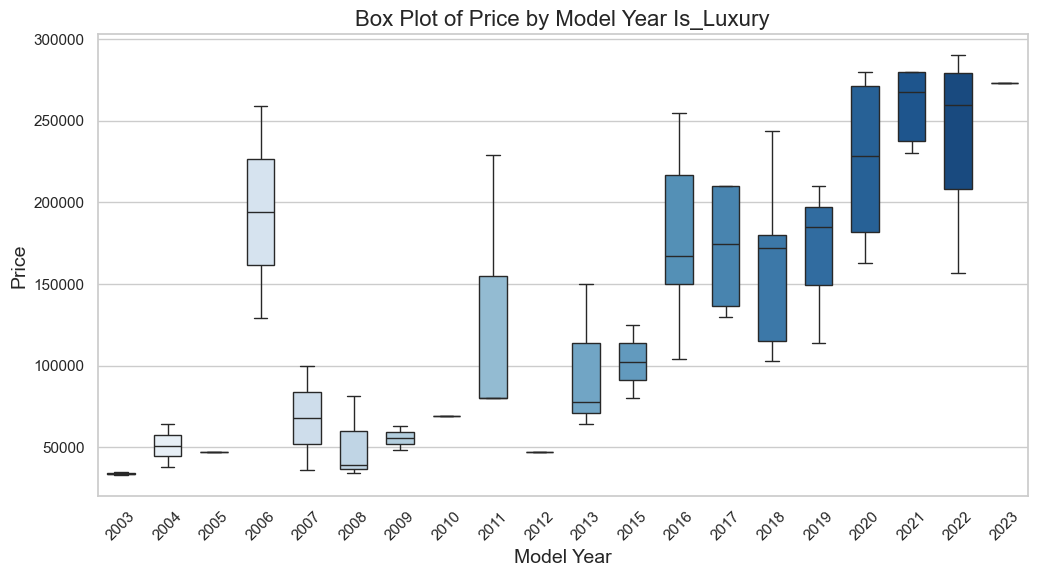

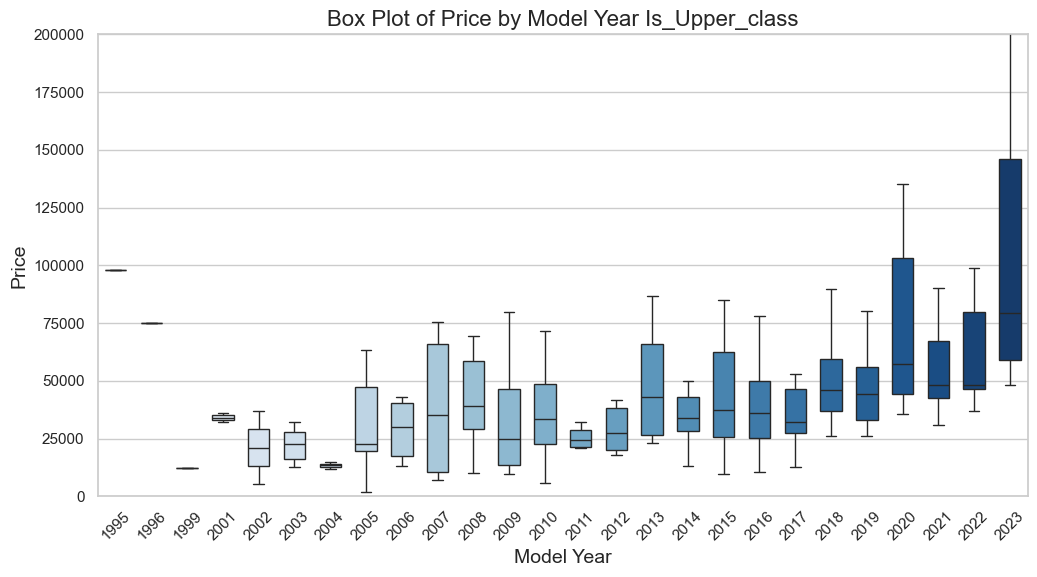

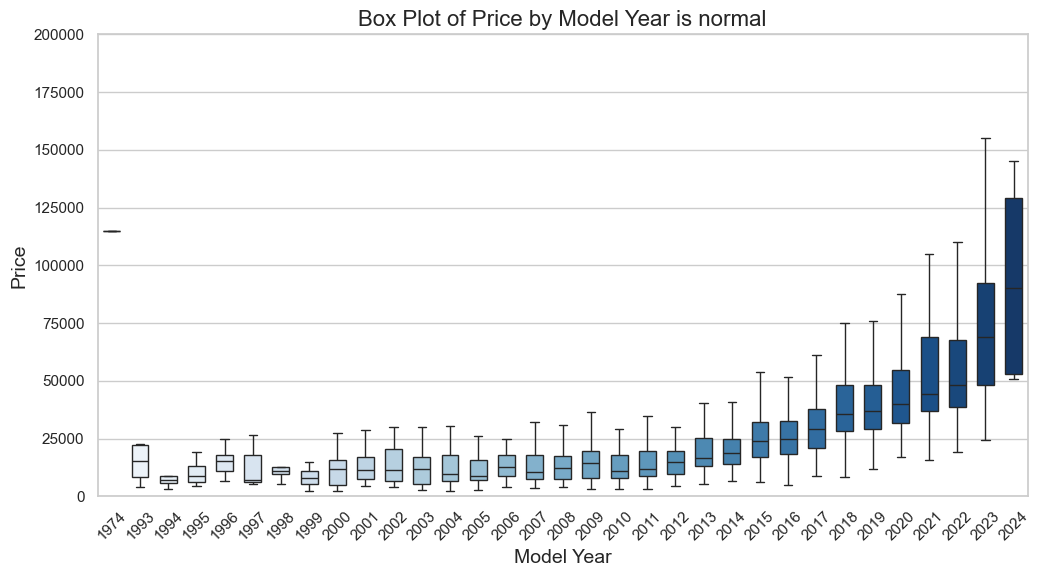

In [73]:
# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=data_split[data_split["Is_Luxury"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=data_split, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year Is_Luxury', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(data_split['model_year'].unique()), 5), labels=data_split['model_year'].unique()[::5])
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=data_split[data_split["Is_Upper_class"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year Is_Upper_class', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=data_split[(data_split["Is_Upper_class"] == 0) & (data_split["Is_Luxury"] == 0)], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year is normal', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

There are large differences between the Box plots indicating that the seperation through the new attribute is helpful. When comparing the boxplot containing only normal cars with the plot with all, we can barely see a difference however. This can be explained by the number of cars represented by the class luxury or normal class. Since most of the cars are normal this leads to the box plot containing all cars converging with the one with only normal cars. 

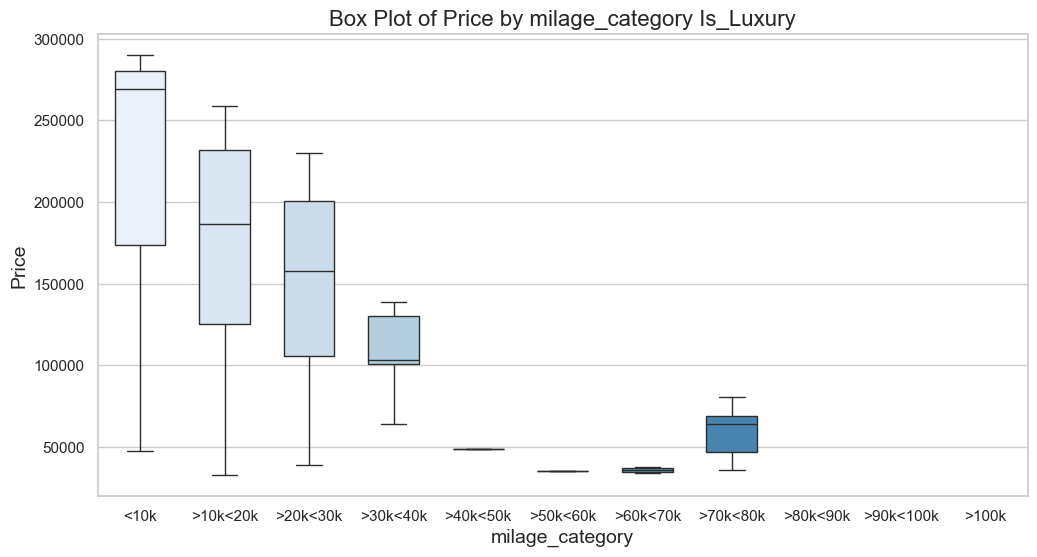

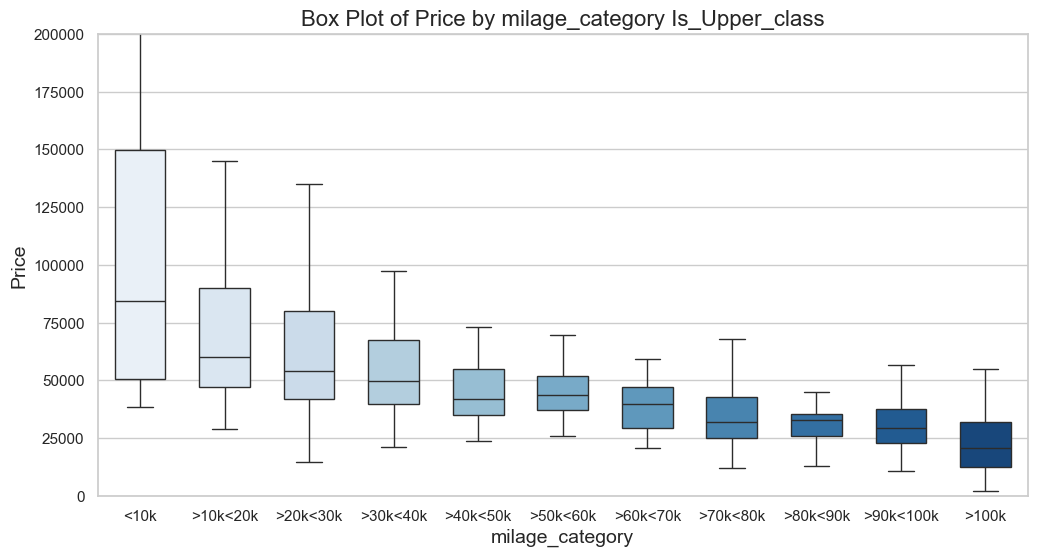

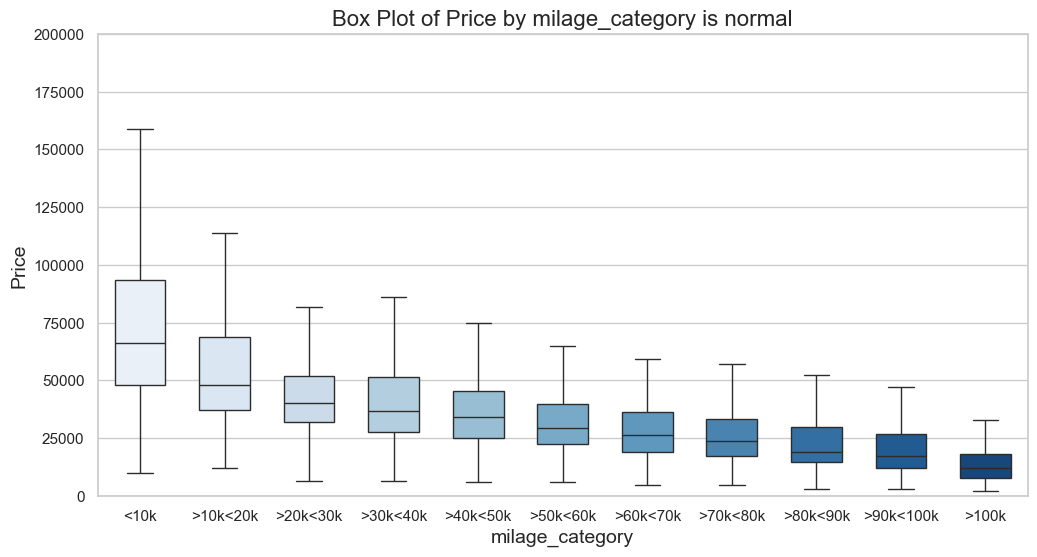

In [68]:
# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_category', y='price', data=data_split[data_split["Is_Luxury"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by milage_category Is_Luxury', fontsize=16)
plt.xlabel('milage_category', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_category', y='price', data=data_split[data_split["Is_Upper_class"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by milage_category Is_Upper_class', fontsize=16)
plt.xlabel('milage_category', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_category', y='price', data=data_split[(data_split["Is_Upper_class"] == 0) & (data_split["Is_Luxury"] == 0)], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by milage_category is normal', fontsize=16)
plt.xlabel('milage_category', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=data_split['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

# Checking the relevanz of Turbo

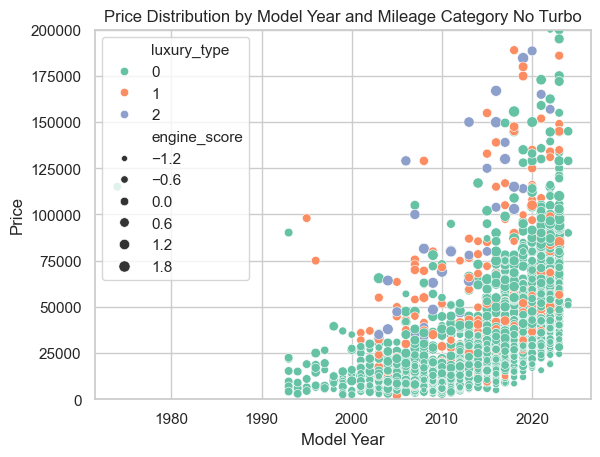

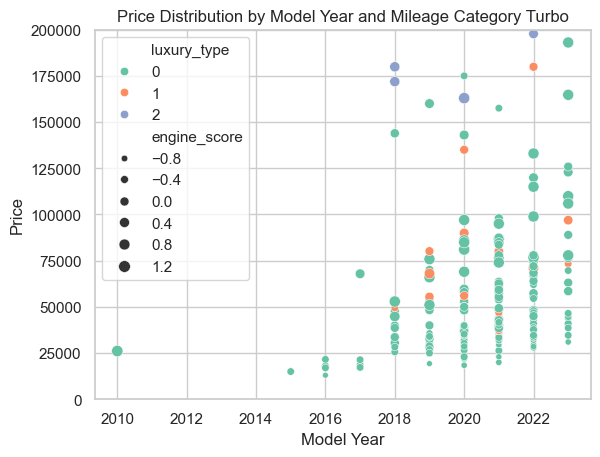

In [69]:


# Create the boxplot
sns.scatterplot(x='model_year', y='price', hue='luxury_type', size="engine_score", data=data_split[data_split["turbo"] == 0], palette="Set2")


# Add titles and labels
plt.title('Price Distribution by Model Year and Mileage Category No Turbo')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.ylim(0,200000)
plt.show()

# Create the boxplot
sns.scatterplot(x='model_year', y='price', hue='luxury_type', size="engine_score", data=data_split[data_split["turbo"] == 1], palette="Set2")


# Add titles and labels
plt.title('Price Distribution by Model Year and Mileage Category Turbo')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.ylim(0,200000)
plt.show()


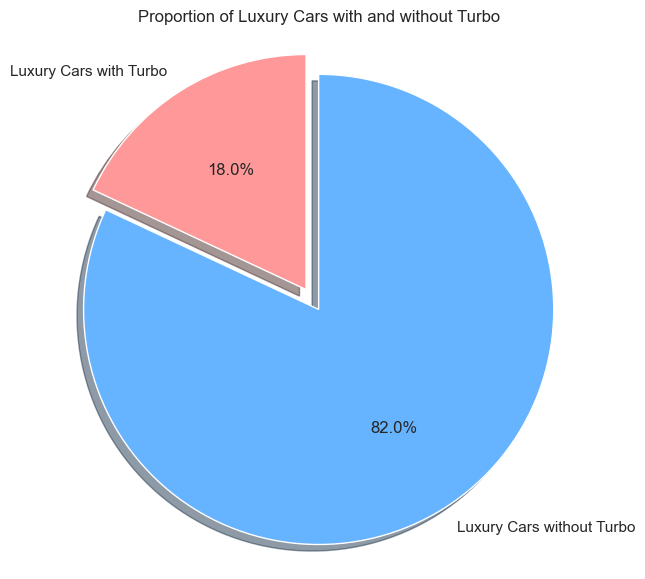

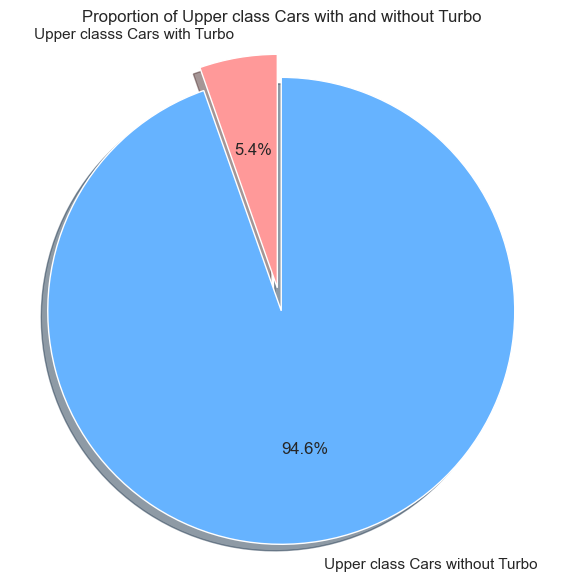

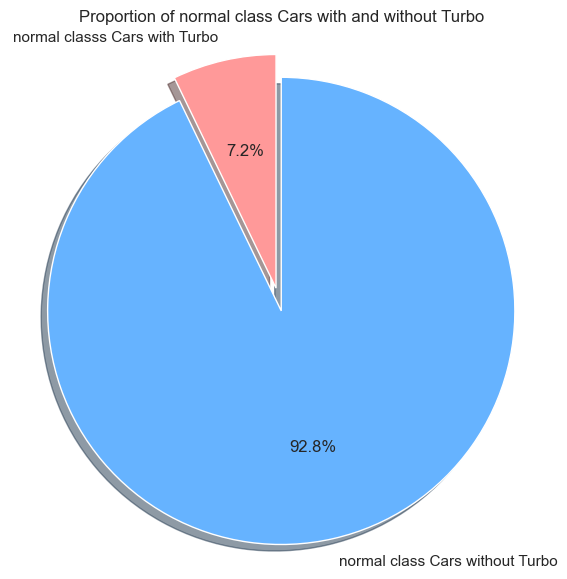

In [70]:
# Filter the data: Select only luxury cars containing turbo
luxury_turbo_cars = data_split[(data_split["Is_Luxury"] == 1) & (data_split["turbo"] == 1)]

# Count the total number of luxury cars and the number of luxury cars with turbo
total_luxury_cars = data_split[data_split["Is_Luxury"] == 1]
luxury_with_turbo = len(luxury_turbo_cars)
luxury_without_turbo = len(total_luxury_cars) - luxury_with_turbo

# Data for the pie chart
labels = ['Luxury Cars with Turbo', 'Luxury Cars without Turbo']
sizes = [luxury_with_turbo, luxury_without_turbo]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Luxury Cars with Turbo)

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
plt.title('Proportion of Luxury Cars with and without Turbo')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()
#####################################################################################################################################################################
# Filter the data: Select only luxury cars containing turbo
luxury_turbo_cars = data_split[(data_split["Is_Upper_class"] == 1) & (data_split["turbo"] == 1)]

# Count the total number of luxury cars and the number of luxury cars with turbo
total_luxury_cars = data_split[data_split["Is_Upper_class"] == 1]
luxury_with_turbo = len(luxury_turbo_cars)
luxury_without_turbo = len(total_luxury_cars) - luxury_with_turbo

# Data for the pie chart
labels = ['Upper classs Cars with Turbo', 'Upper class Cars without Turbo']
sizes = [luxury_with_turbo, luxury_without_turbo]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Luxury Cars with Turbo)

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
plt.title('Proportion of Upper class Cars with and without Turbo')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

#####################################################################################################################################################################
# Filter the data: Select only luxury cars containing turbo
luxury_turbo_cars = data_split[(data_split["luxury_type"] == 0) & (data_split["turbo"] == 1)]

# Count the total number of luxury cars and the number of luxury cars with turbo
total_luxury_cars = data_split[data_split["luxury_type"] == 0]
luxury_with_turbo = len(luxury_turbo_cars)
luxury_without_turbo = len(total_luxury_cars) - luxury_with_turbo

# Data for the pie chart
labels = ['normal classs Cars with Turbo', 'normal class Cars without Turbo']
sizes = [luxury_with_turbo, luxury_without_turbo]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Luxury Cars with Turbo)

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
plt.title('Proportion of normal class Cars with and without Turbo')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

Hypothesis: Int_Col has a surprising cor with price because expensive cars have a unique col (or unique color lead to more exp car). However, due to the scope of our paper we cannot examine what type of color is unique and if this leads to an more expensive car because the colors are too cryptic to differenitate it between expensive/unique color and normal. And for domain knowledge, we can assume that color doesnt have a signicifant impact on the price except if it is an extreme color like neon pink or so. However, due to the unlikehood of this being of higher importance than other essential factors like milage, HP or so, we wont conduct any further research on it.

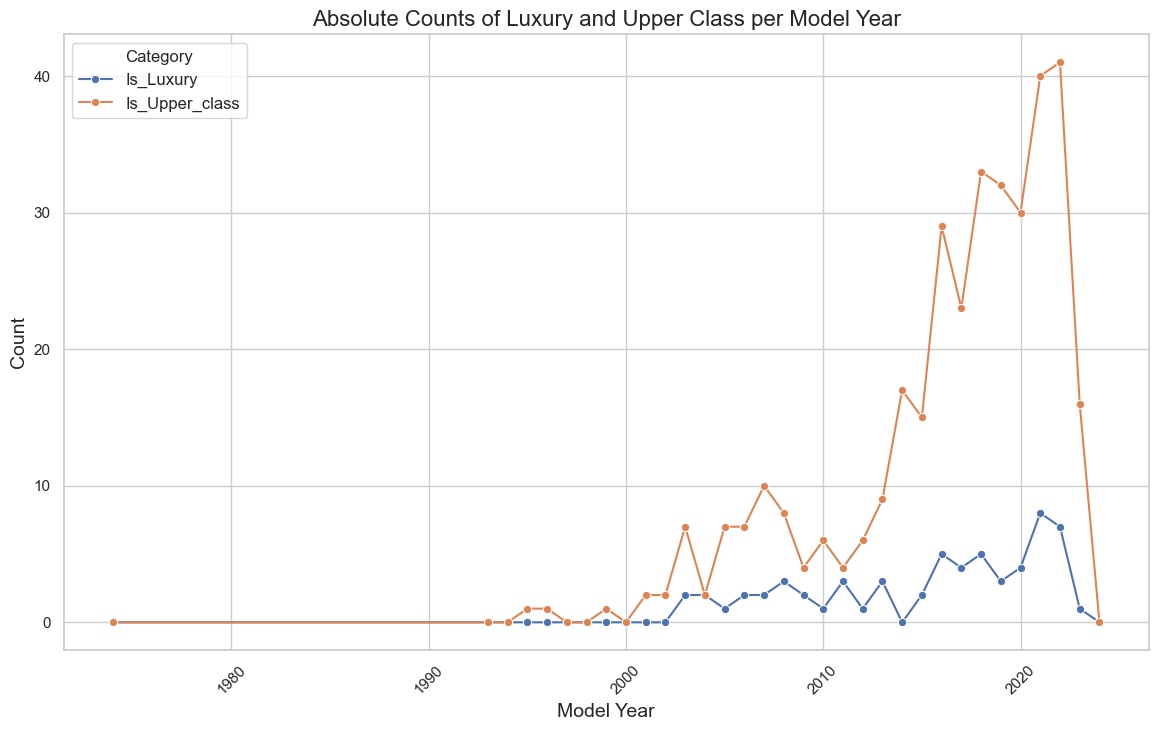

In [72]:
# Count the occurrences of Is_Luxury and Is_Upper_class per model_year
luxury_counts = data_split.groupby('model_year')['Is_Luxury'].sum().reset_index(name='Luxury Count')
upper_class_counts = data_split.groupby('model_year')['Is_Upper_class'].sum().reset_index(name='Upper Class Count')

# Merge the two counts for plotting
counts_per_year = luxury_counts.merge(upper_class_counts, on='model_year')

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=counts_per_year, x='model_year', y='Luxury Count', label='Is_Luxury', marker='o')
sns.lineplot(data=counts_per_year, x='model_year', y='Upper Class Count', label='Is_Upper_class', marker='o')

# Customize the plot
plt.title('Absolute Counts of Luxury and Upper Class per Model Year', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Category", fontsize=12)
plt.grid(True)

plt.show()

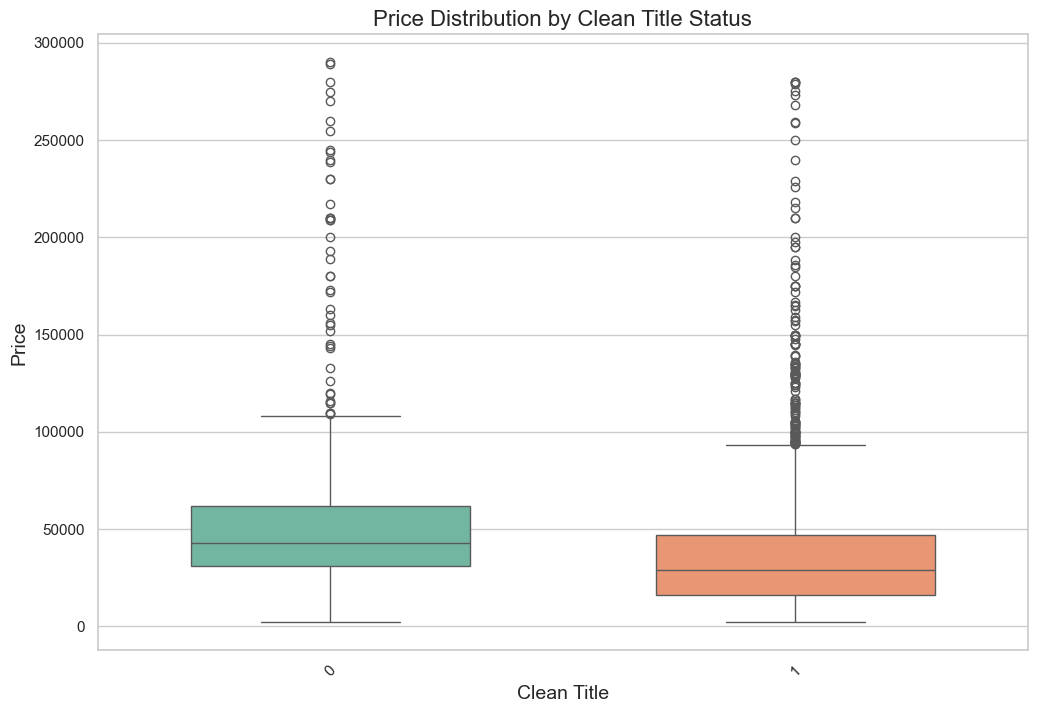

In [74]:
# Prices on clean title

# Set theme for the plot
sns.set_theme(style="whitegrid")

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=data_split,
    x="clean_title",
    y="price",
    palette="Set2",
    width=0.6
)

# Customize the plot
plt.title("Price Distribution by Clean Title Status", fontsize=16)
plt.xlabel("Clean Title", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)

# Show the plot
plt.show()


## CLear outliers

In [82]:
print(data_split)

      model_year    milage  accident  clean_title  price  turbo  is_hybrid  \
0           2000  194277.0         1            1   2300      0          0   
1           2015   13300.0         0            1  62500      0          0   
2           2020   30426.0         1            0  29645      0          0   
3           2020   67072.0         0            1  38500      0          0   
4           2016   99000.0         1            1   5000      0          0   
...          ...       ...       ...          ...    ...    ...        ...   
3198        2004   34254.0         0            1  64250      0          0   
3199        2013   99982.0         1            1   6900      0          0   
3200        1993  120644.0         0            1   4200      0          0   
3201        2021   31181.0         1            1  42442      0          0   
3202        2007   82000.0         1            1   7999      0          0   

      is_gasoline  is_electric  engine_score          brand mil

In [108]:
from scipy.stats import zscore

# Filter the data based on the specified attributes
luxury_data = data_split[data_split['Is_Luxury'] == 1]
upper_class_data = data_split[data_split['Is_Upper_class'] == 1]
neither_data = data_split[(data_split['Is_Luxury'] == 0) & (data_split['Is_Upper_class'] == 0)]

# Define a function to calculate Z-scores for price and identify outliers
def detect_price_outliers(df, threshold=5):
    df['z_score_price'] = zscore(df['price'])  # Calculate Z-score for price
    outliers = df[df['z_score_price'].abs() > threshold]  # Filter rows with Z-score > threshold
    return outliers

# Detect outliers for each group
luxury_outliers = detect_price_outliers(luxury_data)
upper_class_outliers = detect_price_outliers(upper_class_data)
neither_outliers = detect_price_outliers(neither_data)

# Display results
print("Luxury Outliers (Price):")
print(len(luxury_data))
print(luxury_outliers)

print("\nUpper Class Outliers (Price):")
print(len(upper_class_data))
print(upper_class_outliers)

print("\nNeither Luxury nor Upper Class Outliers (Price):")
print(len(neither_data))
print(neither_outliers)


Luxury Outliers (Price):
61
Empty DataFrame
Columns: [model_year, milage, accident, clean_title, price, turbo, is_hybrid, is_gasoline, is_electric, engine_score, brand, milage_category, Is_Luxury, Is_Upper_class, age, luxury_type, z_score_price]
Index: []

Upper Class Outliers (Price):
353
      model_year  milage  accident  clean_title   price  turbo  is_hybrid  \
1540        2023   154.0         0            0  274900      1          0   

      is_gasoline  is_electric  engine_score    brand milage_category  \
1540            1            0         0.467  Porsche            <10k   

      Is_Luxury  Is_Upper_class  age  luxury_type  z_score_price  
1540          0               1    1            1        5.25216  

Neither Luxury nor Upper Class Outliers (Price):
2789
      model_year   milage  accident  clean_title   price  turbo  is_hybrid  \
39          2021   1685.0         0            1  250000      1          0   
175         2022   1087.0         0            1  279000      

In [109]:
from sklearn.neighbors import LocalOutlierFactor

# Function to apply LOF
def apply_lof(df, features, n_neighbors=5):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination="auto", metric="minkowski")
    df = df.copy()  # Avoid modifying the original data
    lof_labels = lof.fit_predict(df[features])  # Predict labels (-1 = outlier, 1 = inlier)
    lof_scores = lof.negative_outlier_factor_  # Get the LOF scores
    df['lof_label'] = lof_labels
    df['lof_score'] = lof_scores
    return df

# Filter data for luxury, upper class, and neither
luxury_data = data_split[data_split['Is_Luxury'] == 1]
upper_class_data = data_split[data_split['Is_Upper_class'] == 1]
neither_data = data_split[(data_split['Is_Luxury'] == 0) & (data_split['Is_Upper_class'] == 0)]

# Features to include in LOF
features = ['milage','price','model_year','engine_score']

# Apply LOF for each group
groups = {'Luxury': luxury_data, 'Upper Class': upper_class_data, 'Neither': neither_data}

for group_name, group_data in groups.items():
    if len(group_data) > 4:  # Ensure there are enough samples for LOF
        group_lof = apply_lof(group_data, features)
        outliers = group_lof[group_lof['lof_label'] == -1]
        if not outliers.empty:
            print(f"Outliers for {group_name}:")
            print(outliers[['model_year', 'engine_score', 'brand', 'price', 'milage']])
            print("-" * 50)


Outliers for Upper Class:
      model_year  engine_score    brand   price   milage
68          2021        -0.517  Porsche   51698  16554.0
493         2022        -0.495    Tesla   36750  12080.0
627         2017        -0.056      RAM   25307  26269.0
1055        2007         0.410  Porsche   75499  73500.0
1329        2018        -0.084      RAM   36990  10339.0
1540        2023         0.467  Porsche  274900    154.0
2489        2023         1.581    Tesla   85000    197.0
2546        2014         0.059  Porsche   68000  78000.0
2635        2017        -0.607  Lincoln   12500  52284.0
2644        2004         0.148  Lincoln   14900  27600.0
2977        1995         0.080  Porsche   97993  49900.0
--------------------------------------------------
Outliers for Neither:
      model_year  engine_score          brand   price    milage
13          2013         0.601         Nissan   59000  101000.0
73          2019        -0.039            BMW   41995   36000.0
181         1999        -

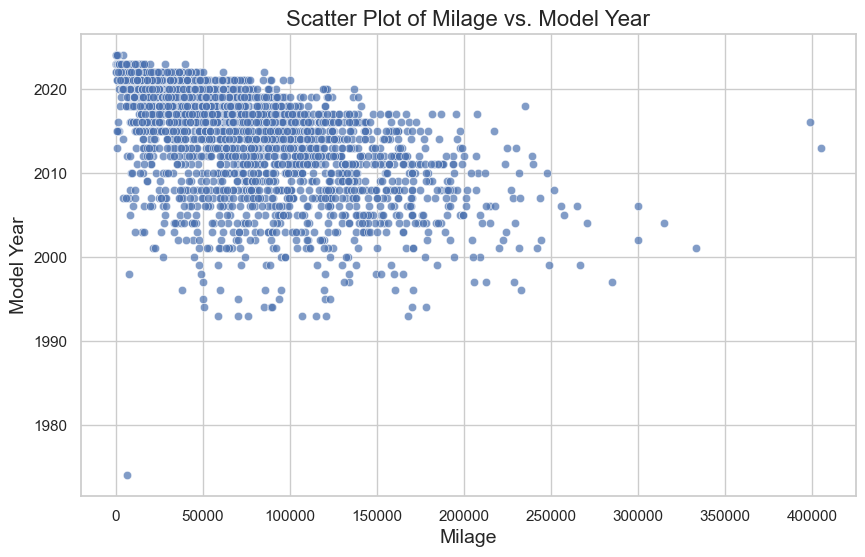

In [111]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_split, x='milage', y='model_year', alpha=0.7)

# Customize the plot
plt.title('Scatter Plot of Milage vs. Model Year', fontsize=16)
plt.xlabel('Milage', fontsize=14)
plt.ylabel('Model Year', fontsize=14)
plt.grid(True)

# Show the plot
plt.show()
